In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_curve,confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
train_set = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num','marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain','capital_loss', 'hours_per_week', 'native_country', 'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels
cat_cols = ['workclass', 'education','marital_status', 'occupation','relationship', 'race', 'sex', 'native_country', 'wage_class']
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
train_set.isnull().sum()
#No null value found but ? is present which represents missing value

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

In [4]:
train_set['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [5]:
train_set.replace(' ?', np.NaN,inplace=True)
test_set.replace(' ?', np.NaN,inplace=True)

In [6]:
train_set.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
wage_class           0
dtype: int64

In [7]:
pd.DataFrame([train_set.dtypes,test_set.dtypes]).T

,0,1
age,int64,int64
workclass,object,object
fnlwgt,int64,int64
education,object,object
education_num,int64,int64
marital_status,object,object
occupation,object,object
relationship,object,object
race,object,object
sex,object,object


In [8]:
for i in train_set.columns: 
    if train_set[i].dtypes == 'object':
        print(i)
      

workclass
education
marital_status
occupation
relationship
race
sex
native_country
wage_class


In [9]:
train_set['workclass'].isnull().sum()

1836

In [10]:
train_set['workclass'].fillna('Missing',inplace=True)

In [11]:
train_set['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', 'Missing', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [12]:
labelEncoder = LabelEncoder()
train_set['wage_class']=labelEncoder.fit_transform(train_set['wage_class'])
test_set['wage_class']=labelEncoder.fit_transform(test_set['wage_class'])

In [13]:
#Target based Mean Encoding

class MeanEncoder(BaseEstimator,TransformerMixin):
    def __init__(self,group_cols,dtype=np.float64):
        assert type(group_cols) == list
        self.dtype = dtype
        self.group_cols = group_cols
    def fit(self,X,y=None):
        self.mapgroup = {}
        for cols in self.group_cols:
            print(cols)
            X[cols].fillna('Missing',inplace=True)
            self.dict = X.groupby([cols])[y].mean().sort_values().to_dict()
            self.mapgroup[cols]=self.dict
        return self
    def transform(self,X,y=None):
        for cols in self.group_cols:
            X[cols].fillna('Missing',inplace=True)
            X[cols] = X[cols].map(self.mapgroup[cols])
        return X



In [14]:
meanenocder = MeanEncoder(group_cols=['workclass','occupation','native_country','marital_status','relationship'])
train_set = meanenocder.fit_transform(X=train_set,y='wage_class')
ordinal = OrdinalEncoder()
train_set[['education','race']]=ordinal.fit_transform(train_set[['education','race']])
onehot = OneHotEncoder(sparse=False)
train_set['sex'] = onehot.fit_transform(train_set[['sex']])[:,0]
train_set.head()
one_hot_attribs = ['sex']
ordinal_attribs = ['education','race']
column_pipeline = ColumnTransformer([
    ("sex",OneHotEncoder(sparse=False),one_hot_attribs),
    ("ordinal",OrdinalEncoder(),ordinal_attribs)
])
train_pipeline = Pipeline([
    ("target_mean",MeanEncoder(group_cols=['workclass','occupation','native_country','marital_status','relationship'])),
])

#train_pipeline.fit_transform(train_set)
X_train  = train_set[train_set.columns[:-1]]
y_train = train_set[train_set.columns[-1]]

scaler =StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)

#Variance Inflation Factor
variables = X_scaled_train
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif["Features"] = X_train.columns
vif




workclass
occupation
native_country
marital_status
relationship


,VIF,Features
0,1.180200,age
1,1.111705,workclass
2,1.022597,fnlwgt
3,1.160049,education
4,1.572965,education_num
5,17.659343,marital_status
6,1.435821,occupation
7,17.944962,relationship
8,1.020212,race
9,1.259932,sex


In [15]:
#Drop marital_status as its highly corelated with relationship
drop_cols=[5]
X_scaled_train = np.delete(X_scaled_train,drop_cols,axis=1)

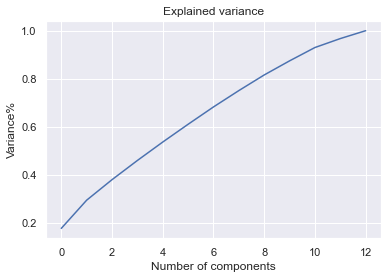

In [16]:
pca = PCA()
principalComponents = pca.fit_transform(X_scaled_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance%')
plt.title('Explained variance')
plt.show()

In [17]:
pca = PCA(n_components=11)
principalComponents = pca.fit_transform(X_scaled_train)


In [18]:
principalComponents.shape

(32561, 11)

In [19]:
model = XGBClassifier(objective='binary:logistic',use_label_encoder=False,disable_default_eval_metric=True)
model.fit(principalComponents,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [20]:
test_set = meanenocder.transform(X=test_set,y='wage_class')
test_set[['education','race']]=ordinal.transform(test_set[['education','race']])
test_set['sex'] = onehot.transform(test_set[['sex']])[:,0]
X_test  = test_set[test_set.columns[:-1]]
y_test = test_set[test_set.columns[-1]]
X_scaled_test = scaler.transform(X_test)
drop_cols=[5]
X_scaled_test = np.delete(X_scaled_test,drop_cols,axis=1)
X_scaled_test.shape
X_scaled_test = pca.transform(X_scaled_test)

0.8455868804127511

In [22]:
y_pred = model.predict(X_scaled_test)
acc = accuracy_score(y_test,y_pred)
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1 = 2* ((precision*recall)/(precision+recall))
auc = roc_auc_score(y_test,y_pred)
print('The Accuracy is ', acc )
print('The precision is ', precision )
print('The recall is ', recall )
print('The F1 score is ', F1 )
print('The AUC score is ', auc )

The precision is  0.927945315641335
The recall is  0.8770236376073574
The F1 score is  0.9017661769302907
The AUC score is  0.7536242438841101


In [23]:
fpr,tpr,threshold = roc_curve(y_test,y_pred)


Text(0.5, 1.0, 'ROC Curve')

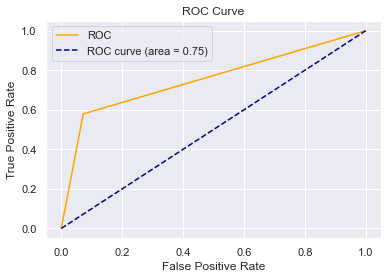

In [24]:
plt.plot(fpr,tpr,color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')

In [25]:
param_grid = { 'learning_rate':[1,0.5,0.1,0.01,0.001],
    'max_depth': [3,5,10,20],
    'n_estimators':[10,50,100,200]}
grid= GridSearchCV(model,param_grid,cv=10)
grid.fit(principalComponents,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     disable_default_eval_metric=True, gamma=0,
                                     gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=8,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                  

In [26]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [28]:
model = XGBClassifier(objective='binary:logistic',use_label_encoder=False,disable_default_eval_metric=True,
                     learning_rate= 0.1, max_depth=5,n_estimators = 100)
model.fit(principalComponents,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1,
              disable_default_eval_metric=True, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [29]:
y_pred = model.predict(X_scaled_test)
acc = accuracy_score(y_test,y_pred)
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat
tp = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tn = conf_mat[1][1]
precision = tp/(tp+fp)
recall = tp/(tp+fn)
F1 = 2* ((precision*recall)/(precision+recall))
auc = roc_auc_score(y_test,y_pred)
print('The Accuracy is ', acc )
print('The precision is ', precision )
print('The recall is ', recall )
print('The F1 score is ', F1 )
print('The AUC score is ', auc )

The Accuracy is  0.8508076899453351
The precision is  0.9368717330116606
The recall is  0.8763351888069806
The F1 score is  0.9055929107233083
The AUC score is  0.7547073173638648


Text(0.5, 1.0, 'ROC Curve')

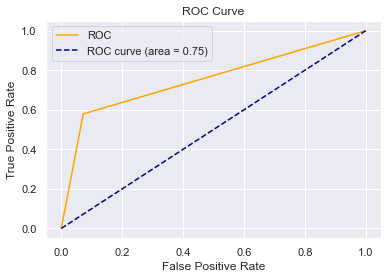

In [30]:
plt.plot(fpr,tpr,color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')